<a href="https://colab.research.google.com/github/HJapok/Palmoil_HDE_Estimate/blob/master/Harvest_Estimation_ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
import os
import pandas as pd
  
# Get the list of all files and directories
# in the root directory
path = "/content/drive/MyDrive/synthetic_dataset"
dir_list = os.listdir(path)
data_arr = []
for i in dir_list:
    img_fol=os.path.join(path, str(i))
    img_list = os.listdir(img_fol)
    for k in img_list:
        data={
            'Filepath':os.path.join(img_fol, str(k)),
            'Day':int(str(k).split('_')[2])
                }
        data_arr.append(data)


image_df = pd.DataFrame(data_arr, 
             columns=['Filepath', 
                      'Day'])
print(image_df.head(5))
        

                                            Filepath  Day
0  /content/drive/MyDrive/synthetic_dataset/ripe/...  130
1  /content/drive/MyDrive/synthetic_dataset/ripe/...  130
2  /content/drive/MyDrive/synthetic_dataset/ripe/...  130
3  /content/drive/MyDrive/synthetic_dataset/ripe/...  130
4  /content/drive/MyDrive/synthetic_dataset/ripe/...  131


In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_df

,Filepath,Day
5838,/content/drive/MyDrive/synthetic_dataset/unrip...,17
9406,/content/drive/MyDrive/synthetic_dataset/overr...,141
15007,/content/drive/MyDrive/synthetic_dataset/under...,58
280,/content/drive/MyDrive/synthetic_dataset/ripe/...,134
5625,/content/drive/MyDrive/synthetic_dataset/unrip...,35
...,...,...
905,/content/drive/MyDrive/synthetic_dataset/ripe/...,140
5192,/content/drive/MyDrive/synthetic_dataset/unrip...,31
12172,/content/drive/MyDrive/synthetic_dataset/under...,87
235,/content/drive/MyDrive/synthetic_dataset/ripe/...,133


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Day',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Day',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Day',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=False
)

Found 8624 validated image filenames.
Found 2156 validated image filenames.
Found 4620 validated image filenames.


In [ ]:
N_mobile = tf.keras.applications.resnet_v2.ResNet50V2( input_tensor = tf.keras.Input(
    shape=(224, 224, 3)), 
    include_top=False, 
    weights='imagenet'
    )

N_mobile.trainable = True
base_model_output = N_mobile.output
flattened_output = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
class_prediction = tf.keras.layers.Dense(64, activation="relu")(flattened_output)
class_prediction = tf.keras.layers.Dense(64, activation="relu")(class_prediction)
class_prediction = tf.keras.layers.Dense(1, activation='linear')(class_prediction)
model = tf.keras.models.Model(inputs=N_mobile.input, outputs=  class_prediction)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200),
    loss='mse',
    metrics=['mse', 'mae']
)
model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 conv3_block2_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block2_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block2_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
          

In [ ]:
import os
checkpoint_filepath = '/content/checkpoint'
if not os.path.exists(checkpoint_filepath):
   os.makedirs(checkpoint_filepath)

filepath=os.path.join(checkpoint_filepath,"weights-improvement-{epoch:02d}-{val_mse:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_mse',
            patience=100,
            restore_best_weights=True
        )

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    verbose=1,
    callbacks=[model_checkpoint_callback,early_stopping]
)

Epoch 1/50
1078/1078 [==============================] - 6753s 6s/step - loss: 177.8155 - mse: 177.8155 - mae: 8.0208 - val_loss: 25.7464 - val_mse: 25.7464 - val_mae: 4.8463
Epoch 2/50
1078/1078 [==============================] - 114s 105ms/step - loss: 8.9609 - mse: 8.9609 - mae: 2.2636 - val_loss: 27.5825 - val_mse: 27.5825 - val_mae: 5.0176
Epoch 3/50
1078/1078 [==============================] - 113s 104ms/step - loss: 13.4979 - mse: 13.4979 - mae: 2.5466 - val_loss: 36.5999 - val_mse: 36.5999 - val_mae: 5.4133
Epoch 4/50
1078/1078 [==============================] - 112s 104ms/step - loss: 9.0146 - mse: 9.0146 - mae: 2.1519 - val_loss: 495.7719 - val_mse: 495.7719 - val_mae: 20.8409
Epoch 5/50
1078/1078 [==============================] - 113s 105ms/step - loss: 4.3270 - mse: 4.3270 - mae: 1.5616 - val_loss: 36.2067 - val_mse: 36.2067 - val_mae: 5.0468
Epoch 6/50
1078/1078 [==============================] - 113s 105ms/step - loss: 8.2192 - mse: 8.2192 - mae: 2.1183 - val_loss: 4.4054

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


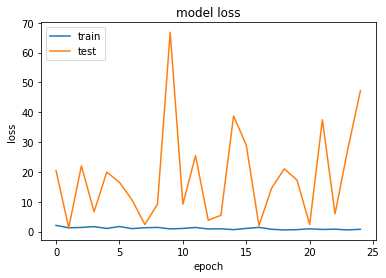

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

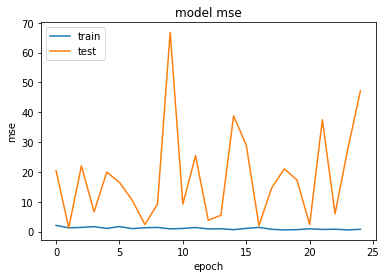

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import os
model_filepath = '/content/drive/MyDrive/Model_ResNet50V2'
if not os.path.exists(model_filepath):
   os.makedirs(model_filepath)

# Save model in json and model weight by h5 
model_json = model.to_json()
with open(os.path.join(model_filepath,"model.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(model_filepath,"model.h5"))
print("Saved model to disk")

Saved model to disk


In [ ]:
# load new model in json format
model_filepath = '/content/drive/MyDrive/Model_ResNet50V2'
json_file = open(os.path.join(model_filepath,"model.json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Model_ResNet50V2/weights-improvement-25-1.42.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200),
    loss='mse',
    metrics=['mse', 'mae']
)

In [ ]:
# Retraining
import os
checkpoint_filepath = '/content/checkpoint'
if not os.path.exists(checkpoint_filepath):
   os.makedirs(checkpoint_filepath)


filepath=os.path.join(checkpoint_filepath,"weights-improvement-{epoch:02d}-{val_mse:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_mse',
            patience=100,
            restore_best_weights=True
        )

history = loaded_model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    verbose=1,
    callbacks=[model_checkpoint_callback,early_stopping]
)

Epoch 1/25
1078/1078 [==============================] - 3012s 3s/step - loss: 2.0523 - mse: 2.0523 - mae: 0.9780 - val_loss: 20.4657 - val_mse: 20.4657 - val_mae: 4.3102
Epoch 2/25
1078/1078 [==============================] - 110s 102ms/step - loss: 1.2383 - mse: 1.2383 - mae: 0.8333 - val_loss: 1.2228 - val_mse: 1.2228 - val_mae: 0.7528
Epoch 3/25
1078/1078 [==============================] - 110s 102ms/step - loss: 1.3692 - mse: 1.3692 - mae: 0.8960 - val_loss: 22.0142 - val_mse: 22.0142 - val_mae: 4.2943
Epoch 4/25
1078/1078 [==============================] - 110s 102ms/step - loss: 1.6364 - mse: 1.6364 - mae: 0.9425 - val_loss: 6.6186 - val_mse: 6.6186 - val_mae: 2.4383
Epoch 5/25
1078/1078 [==============================] - 110s 102ms/step - loss: 1.0329 - mse: 1.0329 - mae: 0.7566 - val_loss: 19.9189 - val_mse: 19.9189 - val_mae: 3.9987
Epoch 6/25
1078/1078 [==============================] - 110s 102ms/step - loss: 1.6601 - mse: 1.6601 - mae: 0.8901 - val_loss: 16.4805 - val_mse: 

In [ ]:
# Retrain and resave
# Save model in json and model weight by h5 
model_json = loaded_model.to_json()
with open("/content/drive/MyDrive/model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("/content/drive/MyDrive/model_weight_2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Direct save model together with model and ist weight
loaded_model.save('/content/drive/MyDrive/model_2.h5')

In [ ]:
# Load the model
modeling = tf.keras.models.load_model('/content/drive/MyDrive/model_2.h5')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predicted_ages = np.squeeze(loaded_model.predict(test_images))
true_ages = test_images.labels

rmse = mean_squared_error(true_ages, predicted_ages)
print("rmse: ", rmse)

r2 = r2_score(true_ages, predicted_ages)
print("r2: ",r2)

rmse:  1.470295353249192
r2:  0.9992463278472086


In [ ]:
from PIL import Image
image_path = "/content/drive/MyDrive/synthetic_dataset/unripe/unripe_day_45_pic_0.png"
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr*1./255
input_arr=input_arr*1./255
input_arr
predictions = loaded_model.predict(input_arr)
print(np.squeeze(predictions))
print(round(float(np.squeeze(predictions))))

44.698288
45


In [ ]:
from PIL import Image
image_path = "/content/drive/MyDrive/synthetic_dataset/unripe/unripe_day_45_pic_32.png"
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr*1./255
input_arr=input_arr*1./255
input_arr
predictions = modeling.predict(input_arr)
print(np.squeeze(predictions))

In [ ]:
from datetime import datetime
from datetime import timedelta

median_ripe_day = 127
predicted_day = 45
day_b4_ripe = median_ripe_day - predicted_day
harvest_date = (datetime.now() + timedelta(days=day_b4_ripe) ).strftime('%Y-%m-%d')
print(harvest_date)